array([[<Axes: title={'center': 'i_f_goals'}>,
        <Axes: title={'center': 'i_f_points'}>],
       [<Axes: title={'center': 'i_f_hits'}>,
        <Axes: title={'center': 'penalityminutes'}>]], dtype=object)

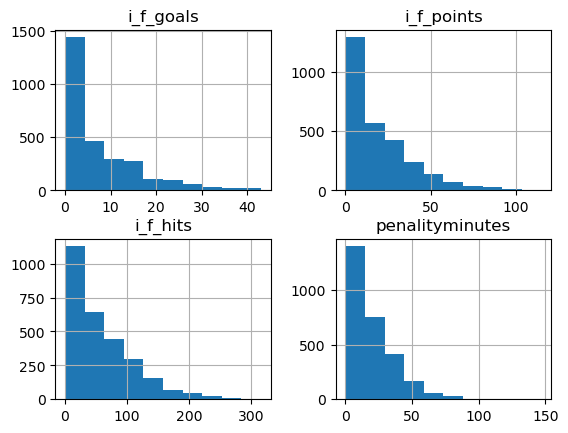

In [147]:
import pandas as pd
from matplotlib import pyplot as plt
import pymc as pm
import seaborn as sns
from pymc import distributions as d
import numpy as np
import arviz as az

df = pd.read_csv('./data/full_data.csv')
df = df.drop(columns = 'Team', axis=1)
df = df[df['season'].astype(int) > 2016]
df.columns = [col.lower() for col in df.columns]

df['salary'] = df['salary'].astype(float).transform('log')
df = df[df['salary'].notna()]

df[['i_f_goals', 'i_f_points', 'i_f_hits', 'penalityminutes']] = df[['i_f_goals', 'i_f_points', 'i_f_hits', 'penalityminutes']].astype('Int64')
df[['i_f_goals', 'i_f_points', 'i_f_hits', 'penalityminutes']].hist()

In [148]:
df['type'] = df['type'].str.split(' ').apply(lambda x: x[0])
df = df[df['type'] == 'Standard']

In [149]:
# df[df['season'] - 1 == df['contract_season']][['name', 'position', 'season', 'contract_season', 'signing date']]
df['season'].value_counts().sort_index()

season
2017    615
2018    595
2019    483
2020    560
2021    363
2022      3
Name: count, dtype: int64

In [151]:
df[['name', 'season', 'signing date']].sort_values(['name', 'season'])

,name,season,signing date
2137,A.J. Greer,2018,2019-08-01
4156,A.J. Greer,2020,2021-08-04
4157,A.J. Greer,2021,2022-07-13
7836,Aaron Ness,2017,2018-05-15
1337,Adam Boqvist,2021,2022-07-06
...,...,...,...
3874,Zack Mitchell,2017,2018-07-13
1086,Zemgus Girgensons,2018,2019-07-05
1087,Zemgus Girgensons,2019,2020-10-08
1088,Zemgus Girgensons,2019,2020-10-08


In [152]:
df.columns

Index(['team', 'merge_name', 'season', 'playerid', 'name', 'position',
       'games_played', 'icetime', 'shifts', 'onice_xgoalspercentage',
       'office_xgoalspercentage', 'penalties', 'faceoffswon',
       'penalityminutes', 'penalityminutesdrawn', 'shotsblockedbyplayer',
       'i_f_goals', 'i_f_primaryassists', 'i_f_secondaryassists', 'i_f_points',
       'i_f_hits', 'player', 'age', 'weight', 'height', 'pos', 'type',
       'extension', 'signing date', 'signing age', 'clause', 'length',
       'signing', 'expiry', 'exp. year', 'cap hit', 'cap hit %', 'aav',
       'salary', 'base salary', 's.bonus', 'p.bonus', 'state/prov', 'country',
       'conference', 'division', 'o6', 'efftaxrate'],
      dtype='object')

<Axes: xlabel='position', ylabel='salary'>

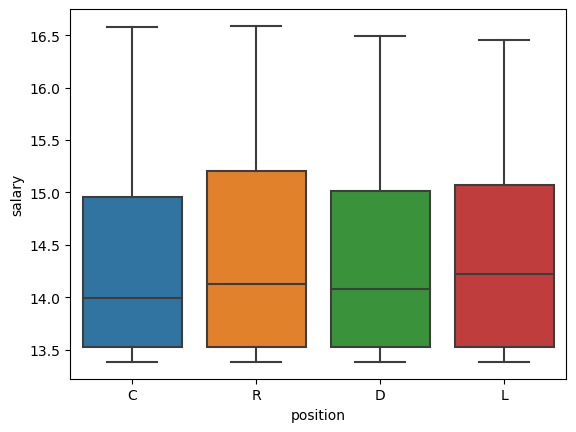

In [153]:
sns.boxplot(data=df, y = 'salary', x = 'position')

<Axes: xlabel='division', ylabel='salary'>

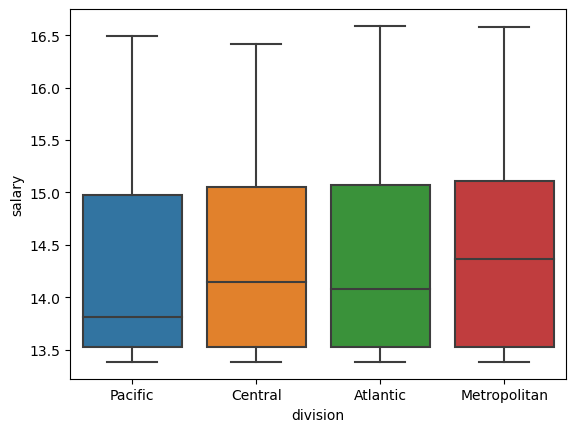

In [154]:
sns.boxplot(data=df, y = 'salary', x = 'division')

<Axes: xlabel='i_f_goals', ylabel='salary'>

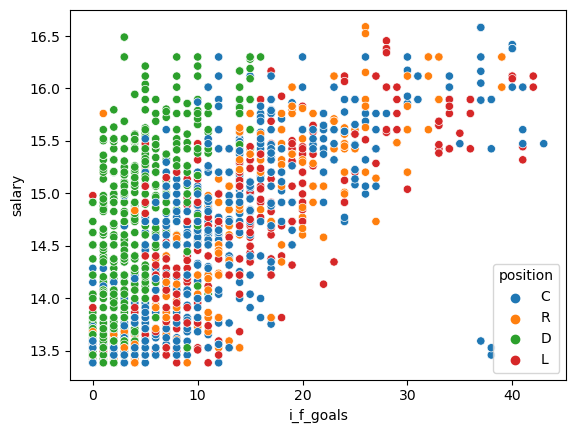

In [155]:
sns.scatterplot(data = df, x = 'i_f_goals', y = 'salary', hue = 'position')

In [156]:
df['clause'] = df['clause'].fillna('No Clause')

In [157]:
coords = {
    'team': df['team'].unique(),
    'players': df['name'].unique(),
    'position': df['position'].unique(),
    'conference': df['conference'].unique(),
    'division': df['division'].unique(),
    'country': df['country'].unique(),
    'state': df['state/prov'].unique(),
    'clause': df['clause'].isna(),
    'type': df['type'].unique(),
    'extension': df['extension'].unique()
}

player_coords = {
    col: pd.factorize(df[col])
    for col in ['conference', 'division', 'country', 'clause', 'type', 'extension', 'name', 'team', 'position', 'state/prov']
}

division_df = df[['division', 'team']].drop_duplicates().sort_values(['division', 'team'])
division_coords = {
    col: pd.factorize(division_df[col])
    for col in ['division', 'team']
}

coords = {
    'division': division_coords['division'][1].values,
    'team': division_coords['team'][1].values,
    'position': player_coords['position'][1].values,
    'clause': player_coords['clause'][1].values,
    'country': player_coords['country'][1].values,
    'type': player_coords['type'][1].values,
    'state': player_coords['state/prov'][1].values
}
print(coords)


{'division': array(['Atlantic', 'Central', 'Metropolitan', 'Pacific'], dtype=object), 'team': array(['BOS', 'BUF', 'DET', 'FLA', 'MTL', 'OTT', 'TBL', 'TOR', 'ARI',
       'CHI', 'COL', 'DAL', 'MIN', 'NSH', 'STL', 'WPG', 'CAR', 'CBJ',
       'NJD', 'NYI', 'NYR', 'PHI', 'PIT', 'WSH', 'ANA', 'CGY', 'EDM',
       'LAK', 'SEA', 'SJS', 'VAN', 'VGK'], dtype=object), 'position': array(['C', 'R', 'D', 'L'], dtype=object), 'clause': array(['M-NTC', 'No Clause', 'NTC', 'NMC', 'M-NTC, NMC', 'NTC, NMC'],
      dtype=object), 'country': array(['USA', 'CA'], dtype=object), 'type': array(['Standard'], dtype=object), 'state': array(['CA', 'AZ', 'MA', 'NY', 'NC', 'OH', 'AB', 'IL', 'CO', 'TX', 'MI',
       'FL', 'MN', 'QC', 'NJ', 'TN', 'ON', 'PA', 'WA', 'MO', 'BC', 'NV',
       'MB', 'DC'], dtype=object)}


In [158]:
df['type'].value_counts()

type
Standard    2619
Name: count, dtype: int64

In [162]:
with pm.Model(coords=coords) as model:

    # data = pm.Data('data', df[['SALARY', 'team']])
    global_alpha = d.Normal('global_alpha', mu=13, sigma=3)
    div_alpha = d.Normal('div_alpha', global_alpha, 3, dims='division')
    team_alpha = d.Normal('team_alpha', div_alpha[division_coords['division'][0]], 1, dims='team')
    team_effect = team_alpha[player_coords['team'][0]]

    # country_alpha = d.Normal('country_alpha', mu=0, sigma=5, dims='country')
    # country_effect = country_alpha[player_coords['country'][0]]

    # state_alpha = d.Normal('state_alpha', mu=0, sigma=5, dims='state')
    # state_effect = country_alpha[player_coords['state/prov'][0]]

    goals_beta = d.Normal('goals', mu=0, sigma=2, dims='position')
    term_beta = d.Normal('term', mu=0, sigma=2, dims='position')
    goal_term_interact = d.Normal('goal_term_interact', mu=0, sigma=2, dims='position')

    goal_effect = goals_beta[player_coords['position'][0]] * df['i_f_goals'].astype(int).values
    term_effect = term_beta[player_coords['position'][0]] * df['length'].astype(int).values
    goal_term_effect = goal_term_interact[player_coords['position'][0]] * df['i_f_goals'].astype(int).values * df['length'].astype(int).values
    player_effects = goal_effect + term_effect + goal_term_effect

    intercept = team_effect 
    contract_sigma = d.HalfNormal('contract_sigma', 2)
    player_mu = intercept + player_effects 
    like = d.Normal('obs', mu=player_mu, sigma=contract_sigma, observed=df['salary'].values)



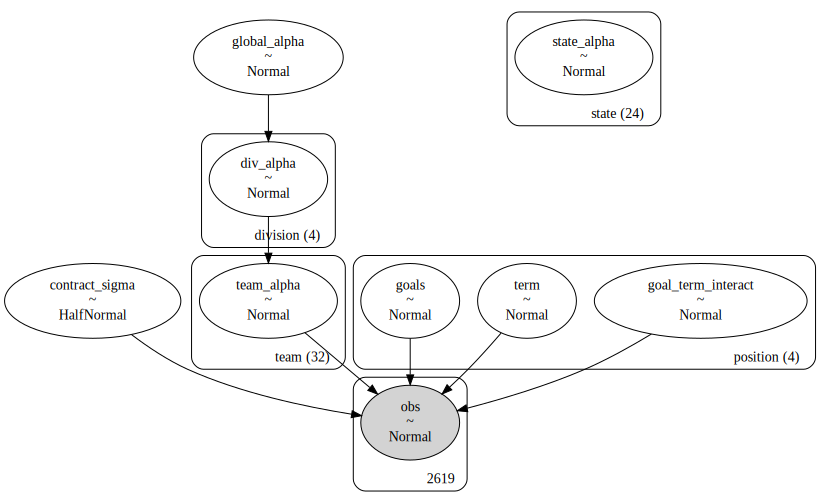

In [163]:
pm.model_to_graphviz(model)

In [164]:
with model:
    trace = pm.sample(1000, chains=4, progressbar=True)

/home/mcanearm/anaconda3/lib/python3.10/site-packages/pymc/logprob/basic.py:216: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(


ValueError: Random variables detected in the logp graph: [normal_rv{0, (0, 0), floatX, False}.out].
This can happen when DensityDist logp or Interval transform functions reference nonlocal variables.

array([[<Axes: title={'center': 'global_salary'}>,
        <Axes: title={'center': 'global_salary'}>],
       [<Axes: title={'center': 'div_alpha'}>,
        <Axes: title={'center': 'div_alpha'}>],
       [<Axes: title={'center': 'team_alpha'}>,
        <Axes: title={'center': 'team_alpha'}>],
       [<Axes: title={'center': 'goals'}>,
        <Axes: title={'center': 'goals'}>],
       [<Axes: title={'center': 'term'}>,
        <Axes: title={'center': 'term'}>],
       [<Axes: title={'center': 'goal_term_interact'}>,
        <Axes: title={'center': 'goal_term_interact'}>],
       [<Axes: title={'center': 'contract_sigma'}>,
        <Axes: title={'center': 'contract_sigma'}>]], dtype=object)

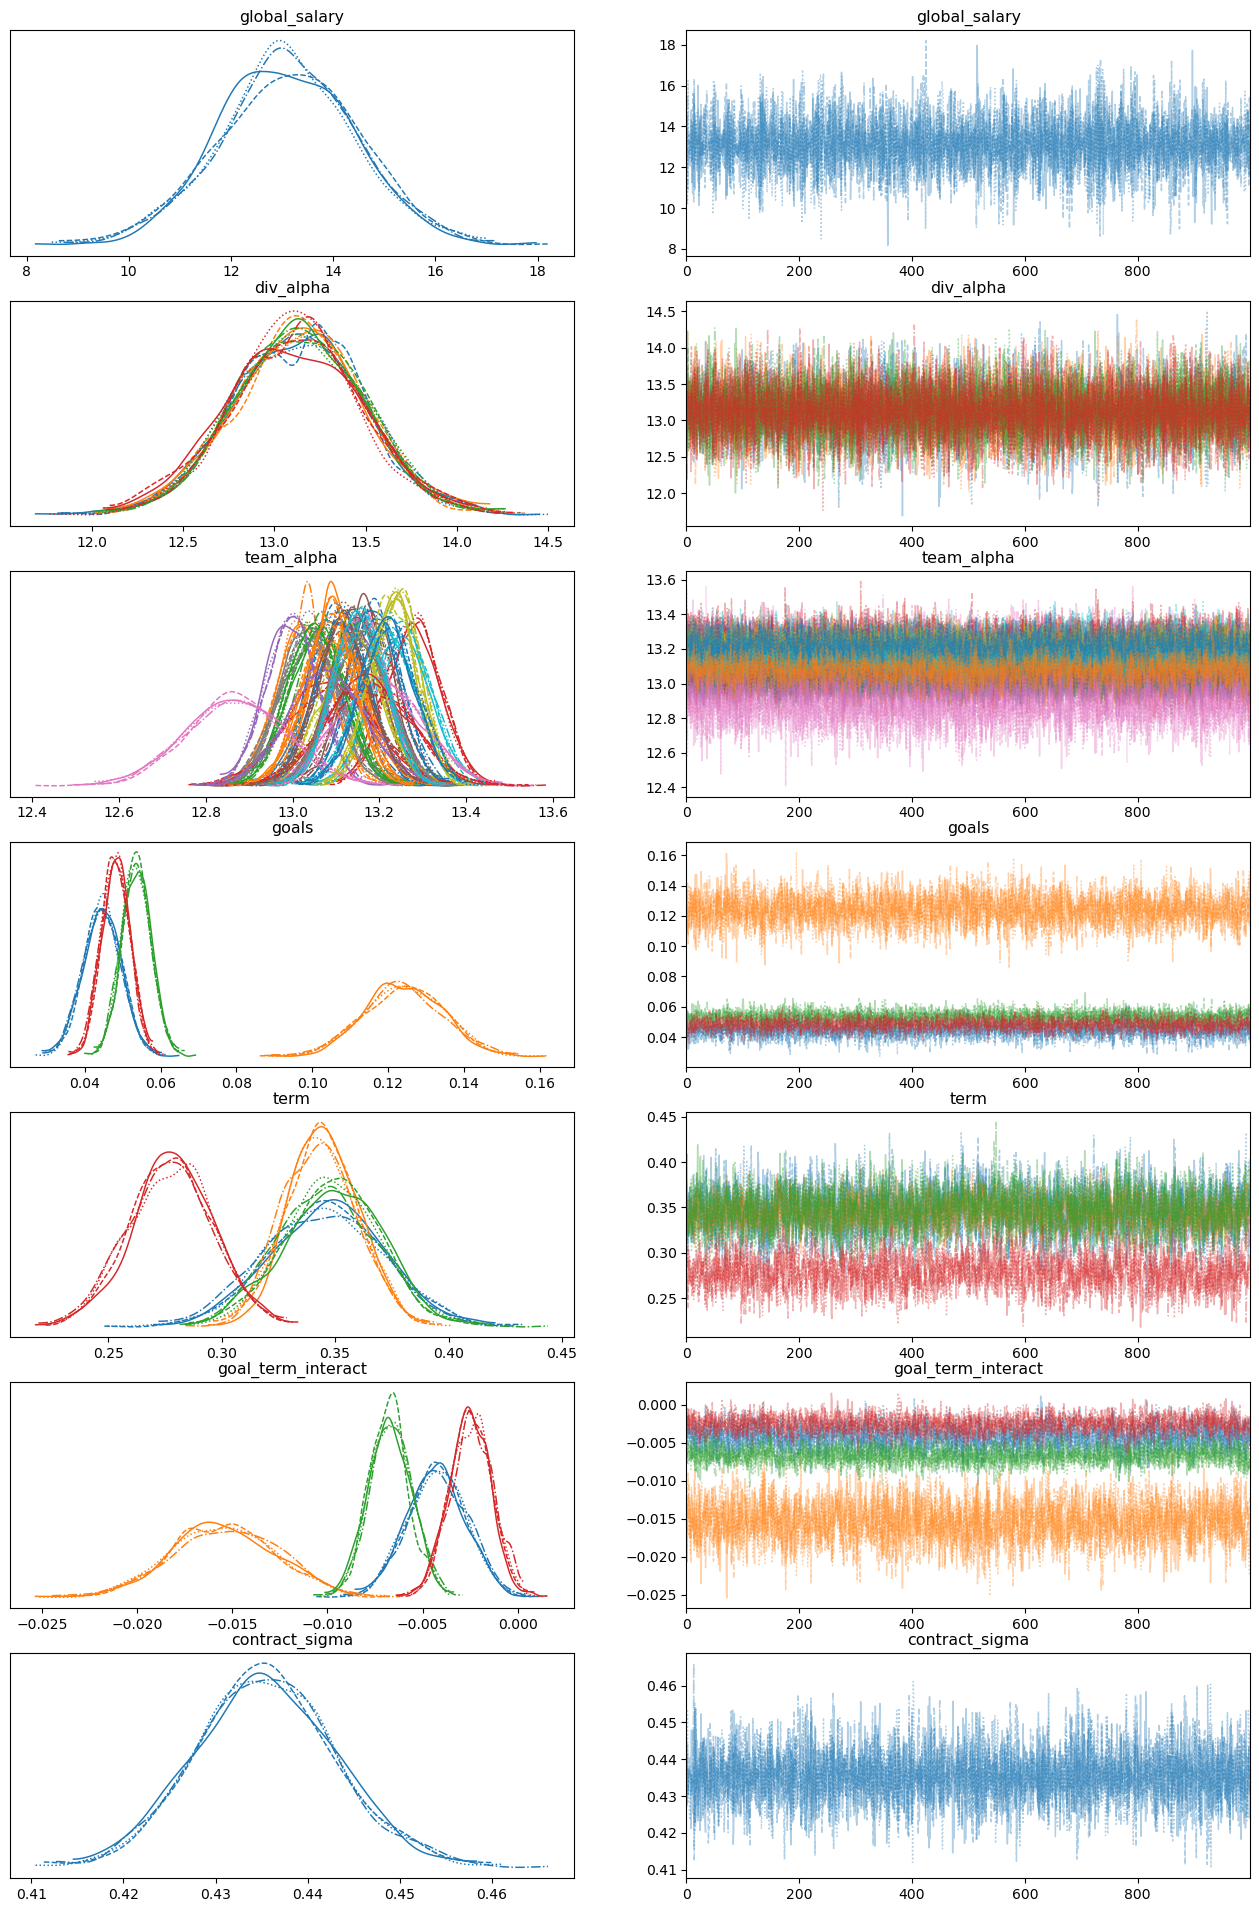

In [ ]:
az.plot_trace(trace, figsize=(16, 24))

In [ ]:
trace.posterior

<xarray.Dataset>
Dimensions:             (chain: 4, draw: 1000, division: 4, team: 32,
                         position: 4)
Coordinates:
  * chain               (chain) int64 0 1 2 3
  * draw                (draw) int64 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * division            (division) <U12 'Atlantic' 'Central' ... 'Pacific'
  * team                (team) <U3 'BOS' 'BUF' 'DET' 'FLA' ... 'SJS' 'VAN' 'VGK'
  * position            (position) <U1 'R' 'D' 'L' 'C'
Data variables:
    global_salary       (chain, draw) float64 12.89 14.47 9.255 ... 15.35 10.84
    div_alpha           (chain, draw, division) float64 13.47 12.92 ... 13.44
    team_alpha          (chain, draw, team) float64 13.14 13.05 ... 13.37 13.17
    goals               (chain, draw, position) float64 0.04326 ... 0.05083
    term                (chain, draw, position) float64 0.2942 0.3445 ... 0.2499
    goal_term_interact  (chain, draw, position) float64 -0.002757 ... -0.001967
    contract_sigma      (chain, draw) float64 0.4423 0.4277 ... 0.4313 0.4436
Attributes:
    created_at:                 2023-04-12T00:35:09.331644
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.2.0
    sampling_time:              12.521242380142212
    tuning_steps:               1000